In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
4537,694,10929,5.11.,양평,-,이태원 클럽 관련,퇴원
4251,980,11785,6.06.,성동구,-,이태원 클럽 관련,퇴원
3677,1554,14081,7.24.,송파구,-,송파구 지인모임,퇴원
5084,147,7544,3.9.,구로구,-,콜센터직원 접촉,퇴원
3610,1621,14412,8.3.,관악구,-,확인 중,퇴원
4314,917,11642,6.04.,강서구,-,수도권 개척교회 관련,퇴원
2596,2635,16710,8.21.,은평구,-,확인 중,퇴원
1300,3931,20094,8.30.,동작구,-,기타 확진자 접촉,퇴원
1789,3442,18740,8.27.,성북구,-,성북구 사랑제일교회 관련,퇴원
25,5206,23586,9.26.,타시도,-,신도림 역사 관련,NaN


In [8]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [9]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [10]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

252


array(['확진자 조사 중', '기타 확진자 접촉', '강남구 소재 대우디오빌플러스', '관악구 삼모스포렉스', '신도림 역사',
       '도봉구 예마루데이케어센터', '강남구 디와이디벨로먼트', '동대문구 성경모임', '확인 중', '송파구 우리교회',
       '해외 접촉 추정', '타시도 확진자 접촉', '중랑구 서울의료원', '종로구 서울대병원',
       '관악구 사랑나무 어린이집', '성동구 덕수고 야구부', '프로그래머 지인모임', '강남구 신도벤처타워',
       '영등포구 LG트윈타워', '관악구 삼모스포렉스 사우나', '강남구 K보건산업', '건축설명회', '종로구청',
       '강남구 통신판매업', '도봉구 소재 아파트', '관악구 지인모임', '영등포 소재 증권회사',
       '서대문구 세브란스병원', '강남구 소재 금융회사', '동작구 요양시설', '양천구 양천경찰서', '은평구 수색성당',
       '서울지방국세청', '수도권 지인모임', '서대문구 지인모임', '영등포 지인모임', '관악구 에바다',
       '광진구 혜민병원', '8.15서울도심집회', '도봉구 건설현장', '도봉구 운동시설', '송파구 쿠팡',
       '노원구 빛가온교회', '서초구 장애인교육시설', '강동구 BF모바일', '영등포구 일련정종 서울포교소',
       '동작구 진흥글로벌', '구로구 아파트', 'KT가좌지사', '성북구 사랑제일교회', '노원구 기도모임',
       '관악구 가족모임', '영등포구 국회출입기자', '은평구 헤어콕', '송파구 소재병원', '극단 산',
       '영등포구 권능교회', '강동구 소재 병원', '다래경매', '성북구 체대입시', '성북구 요양시설',
       '중구소재 은행', '중랑구 소재 체육시설', '동작구 소재 서울신학교', '용인시 우리제일교회', '노원구 손해보험',
       '구로구 보성운수', '강서구 서울대효요양병원', '강북구 일가족', '강서

In [11]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5231,23661,9.27.,강동구,-,확진자 조사 중,NaN
1,5230,23659,9.27.,은평구,-,기타 확진자 접촉,NaN
2,5229,23658,9.27.,동작구,-,확진자 조사 중,NaN
3,5228,23648,9.27.,강남구,-,기타 확진자 접촉,NaN
4,5227,23649,9.27.,강남구,-,강남구 소재 대우디오빌플러스,NaN


In [12]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5231,23661,9-27,강동구,-,확진자 조사 중,NaN
1,5230,23659,9-27,은평구,-,기타 확진자 접촉,NaN
2,5229,23658,9-27,동작구,-,확진자 조사 중,NaN
3,5228,23648,9-27,강남구,-,기타 확진자 접촉,NaN
4,5227,23649,9-27,강남구,-,강남구 소재 대우디오빌플러스,NaN


In [13]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5231,23661,2020-09-27,강동구,-,확진자 조사 중,NaN
1,5230,23659,2020-09-27,은평구,-,기타 확진자 접촉,NaN
2,5229,23658,2020-09-27,동작구,-,확진자 조사 중,NaN
3,5228,23648,2020-09-27,강남구,-,기타 확진자 접촉,NaN
4,5227,23649,2020-09-27,강남구,-,강남구 소재 대우디오빌플러스,NaN


In [14]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
88,5143,23421,2020-09-24,도봉구,-,기타 확진자 접촉,NaN
4890,341,9134,2020-03-24,강서구,-,#8245 접촉,퇴원
3546,1685,14621,2020-08-9,송파구,-,고양시 반석교회 (케네디상가),퇴원
498,4733,22352,2020-09-14,종로구,-,기타 확진자 접촉,NaN
2581,2650,16749,2020-08-21,강북구,-,성북구 사랑제일교회,퇴원


In [15]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5231,23661,2020-09-27,강동구,-,확진자 조사 중,NaN
1,5230,23659,2020-09-27,은평구,-,기타 확진자 접촉,NaN
2,5229,23658,2020-09-27,동작구,-,확진자 조사 중,NaN
3,5228,23648,2020-09-27,강남구,-,기타 확진자 접촉,NaN
4,5227,23649,2020-09-27,강남구,-,강남구 소재 대우디오빌플러스,NaN


In [16]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,5231,23661,2020-09-27,강동구,-,확진자 조사 중,NaN
1,5230,23659,2020-09-27,은평구,-,기타 확진자 접촉,NaN
2,5229,23658,2020-09-27,동작구,-,확진자 조사 중,NaN
3,5228,23648,2020-09-27,강남구,-,기타 확진자 접촉,NaN
4,5227,23649,2020-09-27,강남구,-,강남구 소재 대우디오빌플러스,NaN


In [17]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
2505,2726,16775,2020-08-21,강남구,-,기타 확진자 접촉,퇴원
1520,3711,19576,2020-08-29,기타,-,영등포구 권능교회,퇴원
3632,1599,14300,2020-07-30,강동구,-,강남구 사무실 K빌딩,퇴원
1486,3745,19637,2020-08-28,강동구,-,기타 확진자 접촉,퇴원
3393,1838,15017,2020-08-14,송파구,-,성북구 사랑제일교회,퇴원
2242,2989,17863,2020-08-24,관악구,-,기타 확진자 접촉,퇴원
311,4920,22853,2020-09-18,강서구,-,건축설명회,NaN
4175,1056,11966,2020-06-11,영등포구,-,리치웨이,퇴원
712,4519,21642,2020-09-09,도봉구,-,확인 중,퇴원
8,5223,23644,2020-09-27,구로구,-,관악구 삼모스포렉스,NaN


In [18]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [19]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [20]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
207,2020-01-24,1
191,2020-01-30,3
187,2020-01-31,3
214,2020-02-02,1
199,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [21]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [22]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [23]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [24]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [25]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [26]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [27]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [28]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
21,5210,23607,2020-09-26,관악구,-,확인 중,NaN
23,5208,23589,2020-09-26,강동구,-,확인 중,NaN
39,5192,23574,2020-09-26,송파구,-,확인 중,NaN
41,5190,23553,2020-09-26,타시도,-,확인 중,NaN
46,5185,23562,2020-09-26,도봉구,-,확인 중,NaN
...,...,...,...,...,...,...,...
5175,56,1768,2020-02-25,고양시,-,확인 중,퇴원
5189,42,1370,2020-02-25,노원구,-,확인 중,퇴원
5192,39,924,2020-02-25,평택,-,확인 중,퇴원
5193,38,907,2020-02-25,관악구,-,확인 중,퇴원


In [29]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
141,2020-09-22,9
142,2020-09-23,4
143,2020-09-24,7
144,2020-09-25,4


In [30]:
df_untracked_no = df_untracked_temp

In [31]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [32]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
233,2020-09-13,41.0,8.0
234,2020-09-14,36.0,10.0
235,2020-09-15,49.0,11.0
236,2020-09-16,62.0,24.0
237,2020-09-17,43.0,10.0
238,2020-09-18,40.0,6.0
239,2020-09-19,28.0,11.0
240,2020-09-20,23.0,4.0
241,2020-09-21,39.0,10.0
242,2020-09-22,40.0,9.0


In [33]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[817, 821, 828, 837, 843, 847, 857, 866, 872, 877]


In [34]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [35]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
243,2020-09-23,25,4,847
244,2020-09-24,53,7,857
245,2020-09-25,26,4,866
246,2020-09-26,34,7,872
247,2020-09-27,19,0,877


In [36]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail(10)

,date,new_confirmed,new_untracked,no_paths,new_no_paths
238,2020-09-18,40,6,817,6.0
239,2020-09-19,28,11,821,4.0
240,2020-09-20,23,4,828,7.0
241,2020-09-21,39,10,837,9.0
242,2020-09-22,40,9,843,6.0
243,2020-09-23,25,4,847,4.0
244,2020-09-24,53,7,857,10.0
245,2020-09-25,26,4,866,9.0
246,2020-09-26,34,7,872,6.0
247,2020-09-27,19,0,877,5.0


In [37]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [38]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [39]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [40]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [41]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [42]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [43]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [44]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [45]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [46]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [47]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
243,2020-09-23,25,4,4.0,0,0
244,2020-09-24,53,7,10.0,0,0
245,2020-09-25,26,4,9.0,0,1
246,2020-09-26,34,7,6.0,0,1
247,2020-09-27,19,0,5.0,0,1


### Add Government Social Distancing Policy

In [48]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
238,2020-09-18,40,6,6.0,0,1,0
239,2020-09-19,28,11,4.0,0,1,0
240,2020-09-20,23,4,7.0,0,1,0
241,2020-09-21,39,10,9.0,0,0,0
242,2020-09-22,40,9,6.0,0,0,0
243,2020-09-23,25,4,4.0,0,0,0
244,2020-09-24,53,7,10.0,0,0,0
245,2020-09-25,26,4,9.0,0,1,0
246,2020-09-26,34,7,6.0,0,1,0
247,2020-09-27,19,0,5.0,0,1,0


In [49]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3


In [50]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [51]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.874799,0.874426,-0.025196,0.781420
new_untracked,0.874799,1.000000,0.916445,-0.045178,0.790588
new_no_paths,0.874426,0.916445,1.000000,0.011579,0.843655
is_weekend,-0.025196,-0.045178,0.011579,1.000000,0.012324
gov_policy,0.781420,0.790588,0.843655,0.012324,1.000000


<AxesSubplot:>

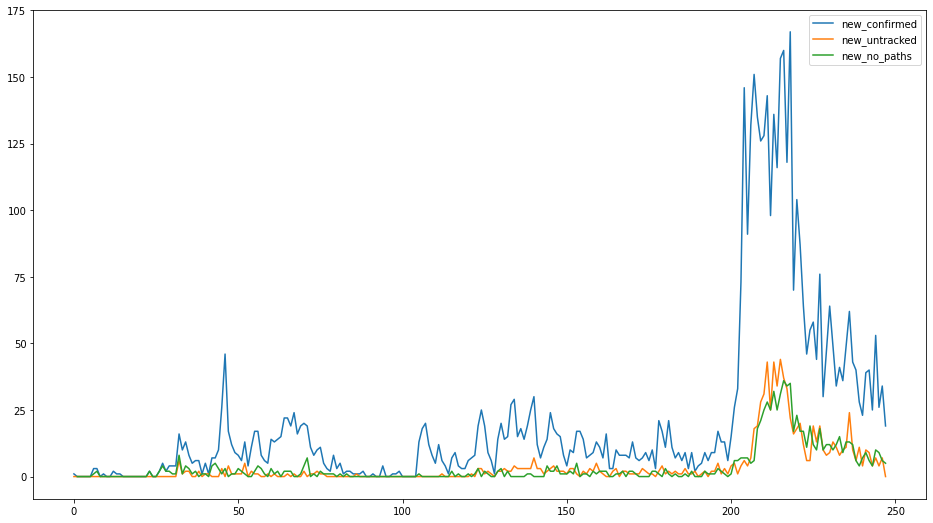

In [52]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

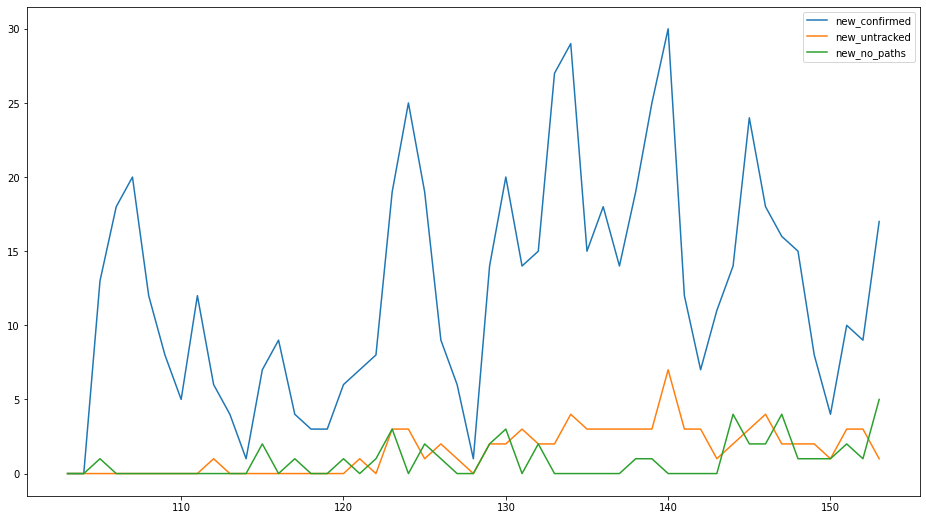

In [53]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

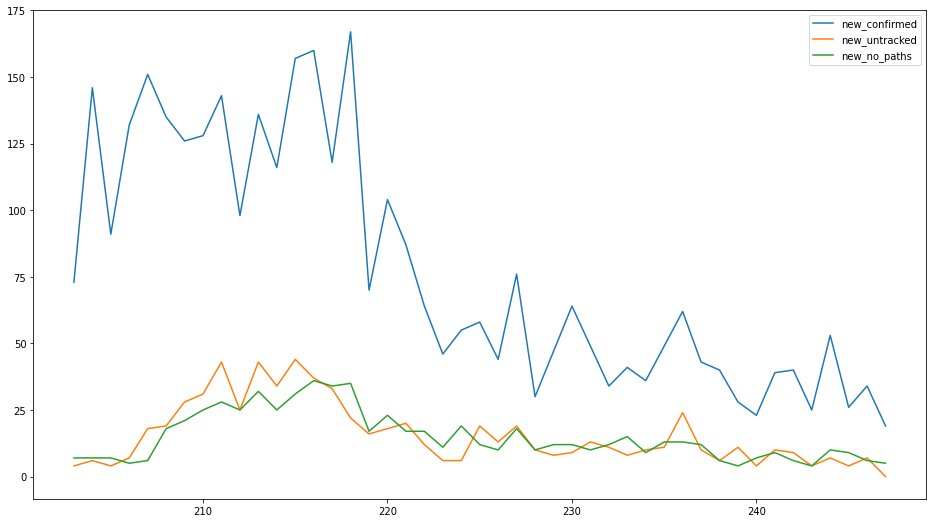

In [54]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

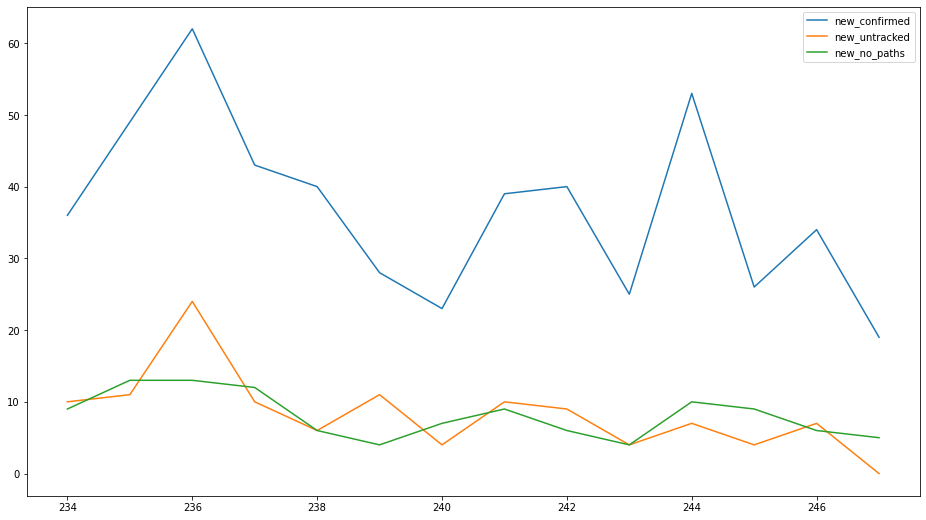

In [55]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

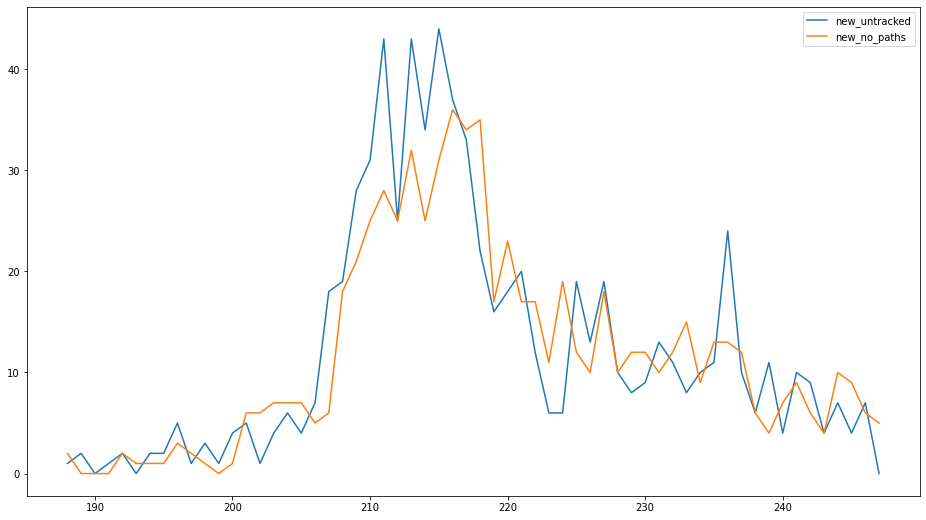

In [56]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
unknown_and_paths_graph = df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))
unknown_and_paths_graph

In [57]:
fig = unknown_and_paths_graph.get_figure()
fig.savefig('./img/unknown_and_paths_graph.png')